In [383]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats

In [384]:
import sys
!{sys.executable} -m pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [385]:
# Downloads 1 year worth of price data
def download(symbol, start=None, days=None):
    end = None
    if not start:
        start = datetime.datetime(2000,1,1)
    if days:
        delta = datetime.timedelta(days=days)
        end = start + delta
    return yf.download(symbol, start=start, end=end)['Adj Close']


In [386]:
download('^SPX', datetime.datetime(2020,1,1))

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02    3257.850098
2020-01-03    3234.850098
2020-01-06    3246.280029
2020-01-07    3237.179932
2020-01-08    3253.050049
                 ...     
2024-05-24    5304.720215
2024-05-28    5306.040039
2024-05-29    5266.950195
2024-05-30    5235.479980
2024-05-31    5277.509766
Name: Adj Close, Length: 1111, dtype: float64

Get the list of current S&P 500 companies

In [387]:
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())


  Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                   Biotechnology   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


Download the historical price data (Adj Close) and construct the design matrix

In [388]:
def construct_data(start, filename):
    df_spx = pd.DataFrame()
    for item in tickers['Symbol']:
        stock = download(item, start, days=365)
        df_spx = pd.concat((df_spx, stock.rename(item)), axis=1)
    df_spx.to_csv(filename)
    return df_spx


In [389]:
filename = 'spx_adj_close.csv'
try:
    df_spx = pd.read_csv(filename, index_col=0)
except FileNotFoundError:
    df_spx = construct_data(datetime.datetime(2020,1,1), filename)

In [390]:

# Clean the data
df_spx = df_spx.reset_index(drop=True)
df_spx.fillna(0, inplace=True)
df_spx = df_spx.loc[(df_spx!=0).any(axis=1)]
df_spx = df_spx.loc[:, (df_spx != 0).all(axis=0)]
df_spx


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,119.836884,44.004036,80.490288,73.511093,196.918198,334.429993,49.099998,17.447662,47.664452,83.502022,...,24.695116,18.037565,192.425308,140.598877,55.022354,75.651688,94.008133,259.140015,140.247604,129.823120
1,118.804962,43.617146,79.509041,72.813347,196.590256,331.809998,48.599998,17.247318,47.333878,82.161324,...,24.737127,18.114357,192.472351,138.513367,55.286964,76.097008,93.713707,256.049988,139.880966,129.842468
2,118.918137,43.893494,79.925598,73.387985,195.306488,333.709991,48.389999,17.447662,47.199883,82.404213,...,24.686710,18.352398,192.707901,138.239197,55.207584,75.604347,93.658493,258.010010,139.072617,128.845627
3,118.438789,43.598732,79.481270,72.969315,191.089859,333.390015,48.250000,17.508636,46.753159,82.656815,...,24.527063,18.352398,192.312241,138.895203,55.092907,75.320099,93.824112,256.470001,138.950394,129.281174
4,120.256310,43.534245,79.805267,73.486473,191.464645,337.869995,47.830002,17.473795,46.896107,83.472870,...,24.619492,18.068287,192.528885,139.766602,55.039982,75.575912,93.989754,247.639999,140.614227,129.000458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,121.017647,51.819920,101.035469,89.475471,245.103210,496.910004,91.550003,21.164497,39.971607,114.695480,...,28.752989,17.305183,198.851471,113.837593,58.215797,95.736237,100.149780,379.739990,140.929718,155.592056
248,121.386284,52.167820,101.881737,89.458122,244.969879,499.859985,91.809998,20.966278,40.256271,114.705276,...,28.958303,17.296846,201.698746,112.939140,58.505474,96.235405,100.853142,376.890015,141.412888,156.438873
249,121.518425,52.299469,101.355164,89.622757,247.235870,498.950012,91.599998,20.993303,40.329723,115.213730,...,28.838539,16.796455,198.013504,114.005440,59.130089,96.350586,102.953850,382.589996,141.071854,158.064392
250,120.920265,51.443798,101.862930,90.705666,245.407898,502.109985,90.620003,21.002319,40.173622,114.627060,...,28.513458,16.746414,197.870621,112.860146,59.220615,95.525040,102.644356,378.040009,144.444885,158.774933


Calculate for the returns matrix R

In [391]:

R = df_spx.pct_change().fillna(0)
R.head()


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.008611,-0.008792,-0.012191,-0.009492,-0.001665,-0.007834,-0.010183,-0.011483,-0.006935,-0.016056,...,0.001701,0.004257,0.000244,-0.014833,0.004809,0.005886,-0.003132,-0.011924,-0.002614,0.000149
2,0.000953,0.006336,0.005239,0.007892,-0.006530,0.005726,-0.004321,0.011616,-0.002831,0.002956,...,-0.002038,0.013141,0.001224,-0.001979,-0.001436,-0.006474,-0.000589,0.007655,-0.005779,-0.007677
3,-0.004031,-0.006715,-0.005559,-0.005705,-0.021590,-0.000959,-0.002893,0.003495,-0.009465,0.003065,...,-0.006467,0.000000,-0.002053,0.004745,-0.002077,-0.003760,0.001768,-0.005969,-0.000879,0.003380
4,0.015346,-0.001479,0.004076,0.007087,0.001961,0.013438,-0.008705,-0.001990,0.003058,0.009873,...,0.003768,-0.015481,0.001127,0.006274,-0.000961,0.003396,0.001765,-0.034429,0.011974,-0.002171


Calculate standardized returns Y

In [392]:
Y = ((R - R.mean(axis=0))/R.std(axis=0)).fillna(0)
# Y.max()

Construct the correlation matrix

In [393]:
def consrtuct_correlation_matrix(Y, filename):
    p = pd.DataFrame(columns=Y.columns, index=Y.columns)
    for i in Y.columns:
        for j in Y.columns:
            # print(Y[i].sum())
            p[i][j] = 1/(len(R.index)-1)*((Y[i] * Y[j]).sum())
    p.head(100)
    p.to_csv(filename)
    return p

# def consrtuct_correlation_matrix_np(Y, filename):
#     # p = pd.DataFrame(columns=Y.columns, index=Y.columns)
#     p = 1/(len(R.index)-1)*np.correlate(Y,Y)
#     p.head(100)
#     p.to_csv(filename)
#     return p



In [394]:
filename_corr = 'correlation_matrix.csv'
try:
    p = pd.read_csv(filename_corr, index_col=0)
except FileNotFoundError:
    p = consrtuct_correlation_matrix(Y, filename_corr)
p.dropna(inplace=True)
p.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
MMM,1.000000,0.670939,0.612062,0.525916,0.666503,0.415643,0.381096,0.531878,0.583711,0.612669,...,0.716285,0.503207,0.546200,0.465998,0.570542,0.749909,0.628406,0.664701,0.595050,0.570718
AOS,0.670939,1.000000,0.456494,0.382923,0.516506,0.410620,0.336607,0.470666,0.499730,0.542161,...,0.599080,0.384128,0.413411,0.456808,0.475589,0.642085,0.459464,0.603629,0.412379,0.444018
ABT,0.612062,0.456494,1.000000,0.623434,0.667716,0.572888,0.504051,0.330373,0.435835,0.717679,...,0.593466,0.325012,0.575755,0.235432,0.677897,0.597317,0.497004,0.588824,0.424979,0.710926
ABBV,0.525916,0.382923,0.623434,1.000000,0.622004,0.541129,0.438898,0.427336,0.487615,0.617008,...,0.512848,0.510147,0.501168,0.371625,0.496597,0.509731,0.472486,0.524845,0.477232,0.649792
ACN,0.666503,0.516506,0.667716,0.622004,1.000000,0.701343,0.519446,0.635935,0.573406,0.723455,...,0.706927,0.552337,0.673242,0.484263,0.611194,0.691977,0.645687,0.706601,0.639994,0.710144


Calculate the Principal Components of the correlation matrix

In [395]:
def pca(X):
    # V = np.cov(X, rowvar=False)
    l, w_prime = np.linalg.eigh(X)
    sorted_indices = np.argsort(l)[::-1]
    l = l[sorted_indices]
    w_prime = w_prime[:, sorted_indices]
    X_rotated = np.dot(X, w_prime)
    variance_explained = l / np.sum(l)
    return X_rotated, w_prime, variance_explained, l


In [396]:
p = np.float64(p)
X_rotated, w_prime, variance_explained, l = pca(p)

Plot of the eigenvalues vs explained variance

Text(0, 0.5, 'variance explained')

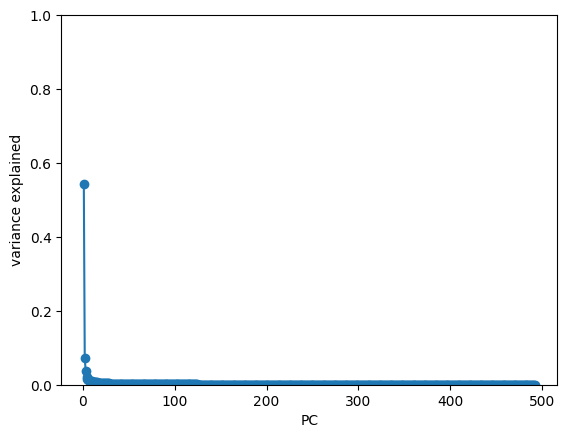

In [397]:
plt.plot(range(1, len(variance_explained)+1), variance_explained, 'o-')
plt.ylim(0,1)
plt.xlabel('PC')
plt.ylabel('variance explained')

Plot the Density of States

Text(0.5, 0, 'Density Of States')

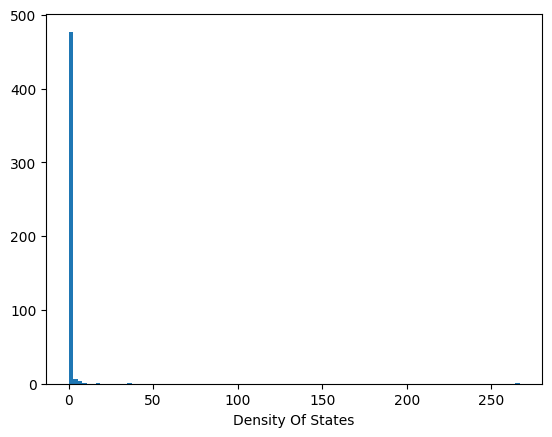

In [398]:
plt.hist(l, bins=100)
plt.xlabel('Density Of States')

Calculate the Eigenportfolio Returns

In [399]:
F = pd.DataFrame(w_prime)
F = F.divide(R.std(axis=0).to_numpy(), axis = 1)
print(F.shape)
print(R.shape)
print(Y.shape)

F = F @ R.T.to_numpy()
F = F.T
# F = F.divide(F.mean(axis=1))
# F = ((F - F.mean(axis=0))/F.std(axis=0)).fillna(0)
# factor = max(np.abs(F[0].min()), np.abs(F[0].max()))
print(F[0].min())

(492, 492)
(252, 492)
(252, 492)
-3.764992159027729


Calculate SPX weighted returns

In [400]:
spx_market = download('^SPX', datetime.datetime(2020,1,1),days=365)
R_market = spx_market.rolling(window=2).apply(lambda x: (x.iloc[1] - x.iloc[0])).fillna(0).reset_index(drop=True)
R_market = ((R_market - R_market.mean(axis=0))/R_market.std(axis=0)).fillna(0)
# R_market = spx_market.pct_change().fillna(0).reset_index(drop=True)
# R_market.head()
# print(R_market.min())
# print(R_market.max())

[*********************100%%**********************]  1 of 1 completed


3.806765687109081


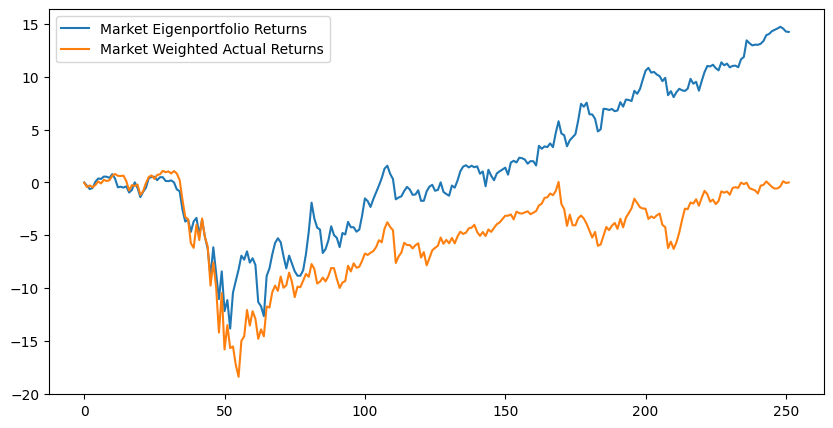

In [401]:
print(max(np.abs(F[0].min()), np.abs(F[0].max())))
# data = F[0]/max(np.abs(F[0].min()), np.abs(F[0].max()))
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(F[0].cumsum(),  label="Market Eigenportfolio Returns")
ax.plot(R_market.cumsum(), label = "Market Weighted Actual Returns")
plt.legend()

In [402]:
import matplotlib.ticker as tck
def plot_eigenportfolio(n):
    E = pd.DataFrame(w_prime)
    E.columns = R.columns
    E = E.sort_values(n,axis=1, ascending=False)
    fig, ax = plt.subplots(1,1, figsize=(15,5), layout='constrained')
    ax.grid(visible=True,which='major')
    major_ticks_x = [x for x in range(len(E.columns))][::5]
    major_labels_x = E.columns[::5]
    ax.set_xticks(major_ticks_x)
    ax.set_xticklabels(major_labels_x, rotation=90)
    ax.plot(E.columns,E.iloc[n])
    ax.set_xlabel(f'Eigenvector {n}')
    plt.hlines(0,0,len(E.columns), colors='black')
    print('Top 10 Stocks')
    list10 = tickers.loc[tickers['Symbol'].isin(E.columns[:10])][['Symbol','Security','GICS Sector']]
    print(list10)

    print('\nBottom 10 Stocks')
    list10 = tickers.loc[tickers['Symbol'].isin(E.columns[-10:])][['Symbol','Security','GICS Sector']]
    print(list10)


Plot the first Eigenvector

Top 10 Stocks
    Symbol                    Security             GICS Sector
7      AES             AES Corporation               Utilities
43     ADM      Archer-Daniels-Midland        Consumer Staples
75    AVGO               Broadcom Inc.  Information Technology
84     CPB       Campbell Soup Company        Consumer Staples
101    CRL  Charles River Laboratories             Health Care
147   DXCM                      Dexcom             Health Care
156    DOW                    Dow Inc.               Materials
174   EPAM                EPAM Systems  Information Technology
190   FFIV                    F5, Inc.  Information Technology
492    WRK                    WestRock               Materials

Bottom 10 Stocks
    Symbol                   Security  GICS Sector
52     AVB      AvalonBay Communities  Real Estate
68      BX                 Blackstone   Financials
86     CAH            Cardinal Health  Health Care
92    CBOE        Cboe Global Markets   Financials
109   CINF       Cin

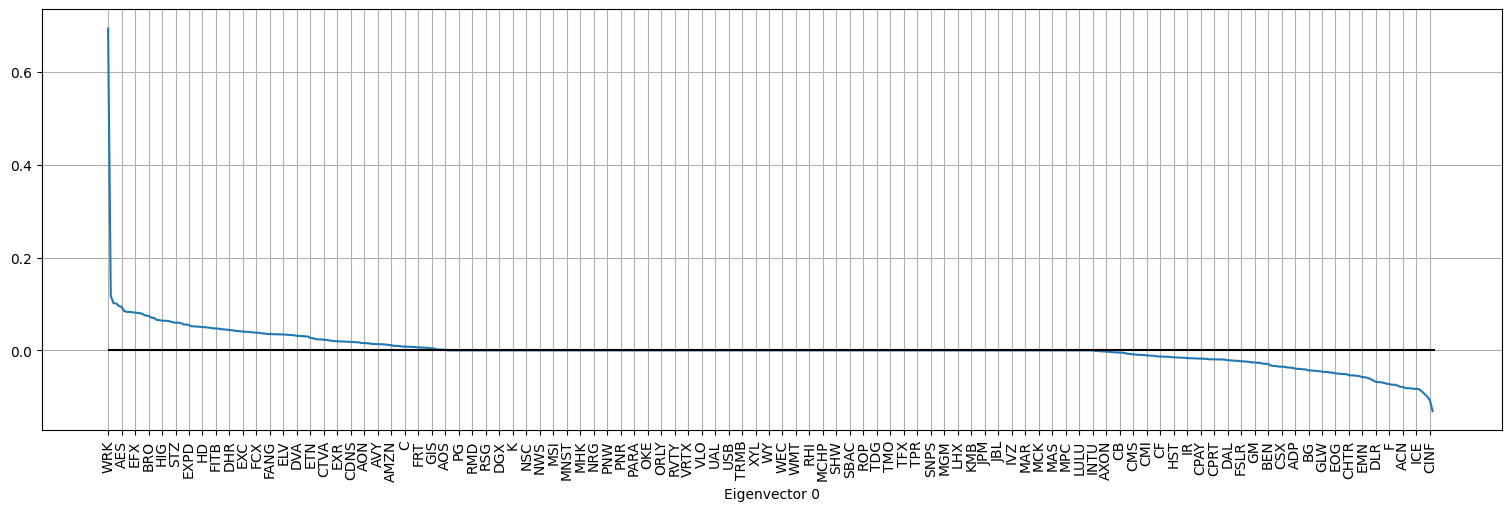

In [403]:
plot_eigenportfolio(0)

Plot Second Eigenvector

Top 10 Stocks
    Symbol                      Security       GICS Sector
23    AMCR                         Amcor         Materials
28     AIG  American International Group        Financials
38     APA               APA Corporation            Energy
48     ATO                  Atmos Energy         Utilities
84     CPB         Campbell Soup Company  Consumer Staples
113    CFG      Citizens Financial Group        Financials
115    CME                     CME Group        Financials
124     ED           Consolidated Edison         Utilities
139    DHR           Danaher Corporation       Health Care
159    DUK                   Duke Energy         Utilities

Bottom 10 Stocks
    Symbol                 Security             GICS Sector
6      AMD   Advanced Micro Devices  Information Technology
44    ANET          Arista Networks  Information Technology
58      BK  Bank of New York Mellon              Financials
60     BAX     Baxter International             Health Care
111   CSCO         

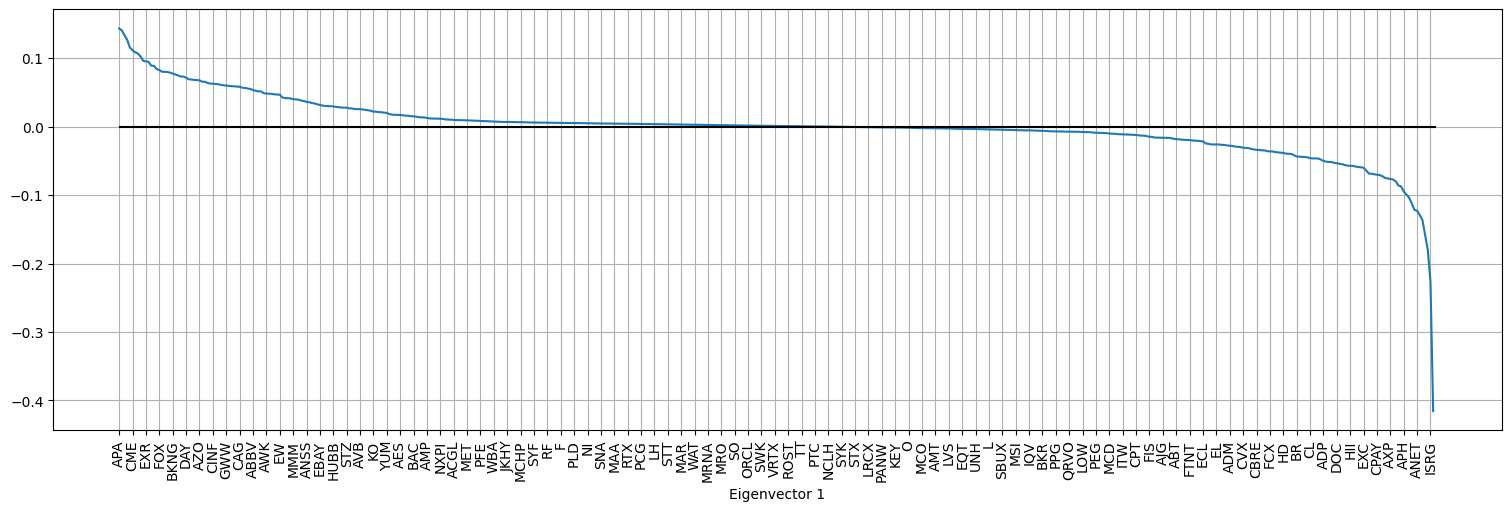

In [404]:
plot_eigenportfolio(1)

Plot Third Eigenvector

Top 10 Stocks
    Symbol                  Security             GICS Sector
161    EMN  Eastman Chemical Company               Materials
173    EOG             EOG Resources                  Energy
209   GRMN                    Garmin  Consumer Discretionary
229   HSIC              Henry Schein             Health Care
236    HON                 Honeywell             Industrials
251     IR            Ingersoll Rand             Industrials
261   INVH          Invitation Homes             Real Estate
479    GWW            W. W. Grainger             Industrials
499    YUM               Yum! Brands  Consumer Discretionary
502    ZTS                    Zoetis             Health Care

Bottom 10 Stocks
    Symbol                Security             GICS Sector
85     COF             Capital One              Financials
105    CMG  Chipotle Mexican Grill  Consumer Discretionary
115    CME               CME Group              Financials
146    DVN            Devon Energy                  Energy
18

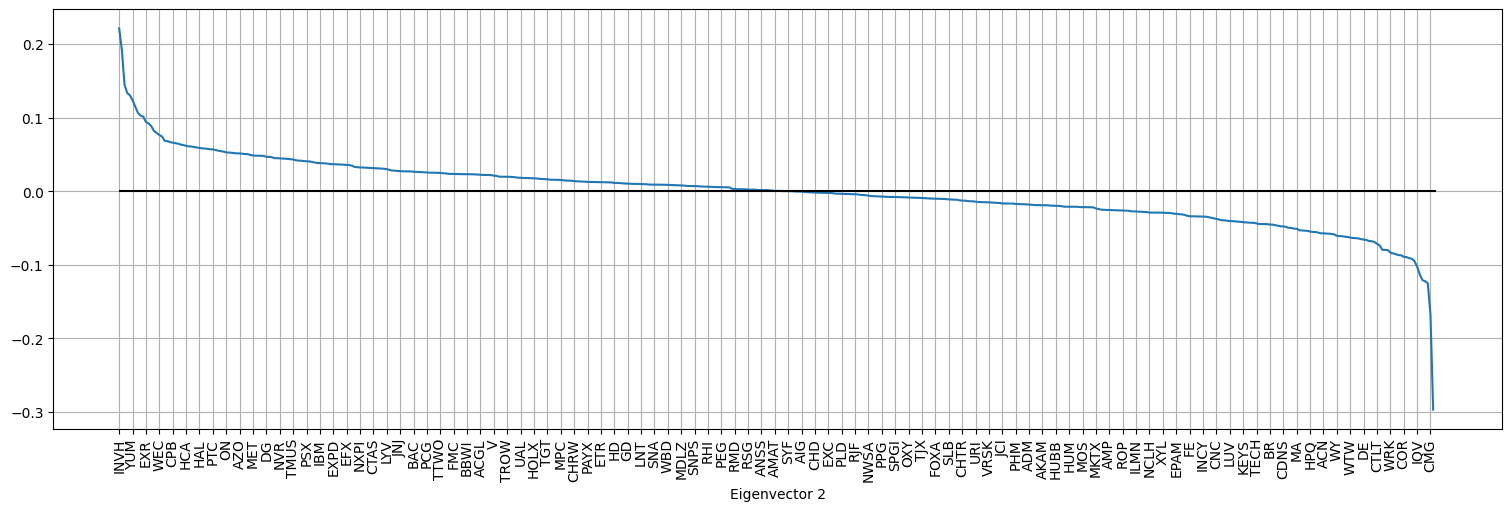

In [405]:
plot_eigenportfolio(2)

Repeat the PCA on data right after the data we used

In [406]:
filename2 = 'spx2_adj_close.csv'
try:
    df_spx = pd.read_csv(filename2, index_col=0)
except FileNotFoundError:
    df_spx = construct_data(datetime.datetime(2021,1,1), filename2)

In [407]:
# Clean the data
df_spx = df_spx.reset_index(drop=True)
df_spx.fillna(0, inplace=True)
df_spx = df_spx.loc[(df_spx!=0).any(axis=1)]
df_spx = df_spx.loc[:, (df_spx != 0).all(axis=0)]

Calculate Standardized Returns

In [408]:

R = df_spx.pct_change().fillna(0)
# R.head()

In [409]:
Y = ((R - R.mean(axis=0))/R.std(axis=0)).fillna(0)
Y.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,-0.029788,-0.117791,-0.087003,-0.099778,-0.164317,-0.042904,-0.079102,-0.023993,-0.107264,-0.098396,...,-0.068925,-0.096327,-0.049763,0.021421,-0.025263,-0.063298,-0.106570,-0.110953,0.038809,-0.135136
1,-0.174725,0.252332,0.839940,0.718846,0.296052,-0.003670,0.110971,1.784083,0.019065,0.530305,...,0.483604,2.019711,-0.579779,1.191272,-0.837086,-0.151534,-0.098225,0.255384,1.162686,0.422657
2,1.276851,1.846900,-0.242992,-0.783654,0.719843,-2.213760,-1.060877,2.129057,2.901349,2.010268,...,0.231254,2.563414,0.484714,0.249088,1.819277,3.028245,0.376681,2.014797,1.889821,1.040776
3,-2.234073,0.583001,0.640231,0.747527,0.598646,1.290640,1.916830,-0.563131,-0.540917,1.947743,...,0.493215,0.033380,0.433469,-0.355772,-1.654374,3.263337,-0.777763,1.942387,-0.346274,-0.206971
4,-1.598770,-0.790013,0.121654,0.315671,0.130615,0.795249,-0.306615,1.479085,-0.438684,0.450169,...,-0.469108,-0.873233,-0.547919,-0.227947,0.741625,-0.806481,1.187648,-0.614697,-0.103900,0.396901


Construct The Correlation Matrix

In [410]:
filename_corr2 = 'correlation_matrix2.csv'
try:
    p = pd.read_csv(filename_corr2, index_col=0)
except FileNotFoundError:
    p = consrtuct_correlation_matrix(Y, filename_corr2)
p.dropna(inplace=True)
p.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
MMM,1.000000,0.385137,0.068908,0.135346,0.335540,-0.047760,-0.109568,0.009261,0.436516,0.080504,...,0.298308,0.279410,0.215074,0.076067,0.248373,0.386632,0.251116,0.134620,0.205106,0.072789
AOS,0.385137,1.000000,0.144234,0.277864,0.438137,0.131520,0.082836,0.344059,0.515863,0.320216,...,0.456162,0.319964,0.299602,0.224158,0.176503,0.574473,0.296499,0.366605,0.279389,0.263068
ABT,0.068908,0.144234,1.000000,0.240184,0.335359,0.357808,0.154575,0.210763,0.030038,0.443757,...,0.065806,-0.056447,0.171835,-0.088445,0.198442,0.172696,0.102876,0.197494,0.158723,0.426964
ABBV,0.135346,0.277864,0.240184,1.000000,0.282936,0.145290,0.031540,0.241075,0.242228,0.228977,...,0.194498,0.192704,0.101958,0.039344,0.186610,0.128015,0.198610,0.152917,0.250681,0.325545
ACN,0.335540,0.438137,0.335359,0.282936,1.000000,0.415933,0.252630,0.336568,0.400420,0.476354,...,0.399030,0.240702,0.357843,0.110647,0.240546,0.508638,0.374585,0.483396,0.330652,0.550787


Perform PCA

In [411]:
X_rotated, w_prime, variance_explained, l = pca(p)

Plot Principal Components vs explained variance

Text(0, 0.5, 'variance explained')

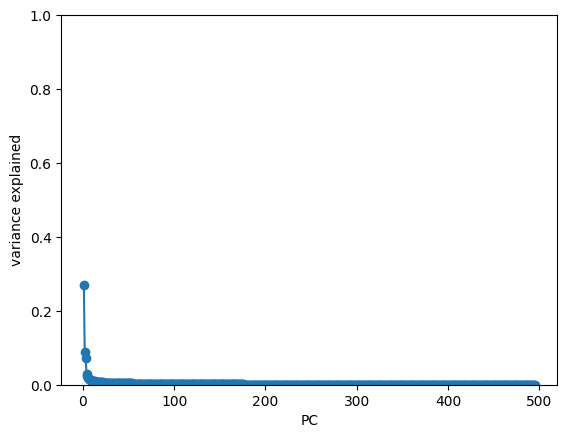

In [412]:
plt.plot(range(1, len(variance_explained)+1), variance_explained, 'o-')
plt.ylim(0,1)
plt.xlabel('PC')
plt.ylabel('variance explained')

Plot the Density of States

Text(0.5, 0, 'Density Of States')

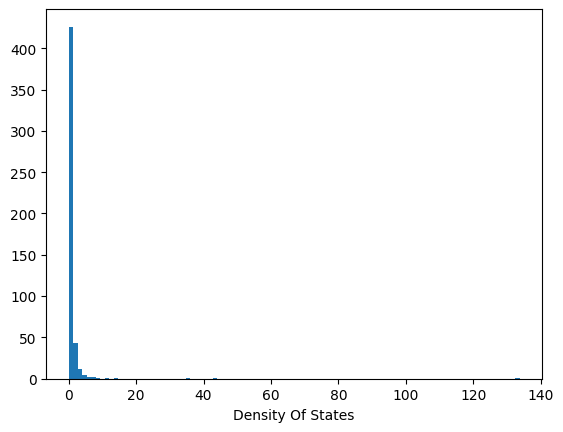

In [413]:
plt.hist(l, bins=100)
plt.xlabel('Density Of States')

Calculate the Eigenportfolio Returns

In [414]:
F = pd.DataFrame(w_prime)
F = F.divide(R.std(axis=0).to_numpy(), axis = 1)
print(F)
print(R)

F = F @ R.T.to_numpy()
F = F.T

          0         1         2         3         4         5         6    \
0    3.350098  0.561664 -5.219477  3.271823 -8.304739 -3.559100  2.363940   
1    4.832585  0.024739 -1.025109  5.553880  2.502708 -2.982055 -0.632561   
2    1.468787 -4.327528 -0.078904  2.776328  1.494796  2.784710 -1.630652   
3    2.641515 -1.219335 -1.596664  1.179200  0.883326  6.343971  1.237304   
4    4.719111 -3.195296 -0.047421  1.664996  0.353996  0.879627  2.329185   
..        ...       ...       ...       ...       ...       ...       ...   
490  5.360159 -0.485511  1.005161  5.276668  2.077599 -4.024485  0.734708   
491  3.962191 -1.339384 -1.365865 -2.261890  2.360514 -1.389582  2.107316   
492  4.009951 -2.161478  4.520641  1.667950 -1.751374 -1.581061 -1.426780   
493  4.082491 -0.144560 -0.313594 -6.088939  3.645024  1.417917  0.621014   
494  2.935196 -5.080639  1.062665  1.341635  3.391792  1.898547  1.500716   

          7         8         9    ...       485        486       487  \
0 

In [415]:
spx_market = download('^SPX', datetime.datetime(2021,1,1),days=365)
R_market = spx_market.rolling(window=2).apply(lambda x: (x.iloc[1] - x.iloc[0])).fillna(0).reset_index(drop=True)
R_market = ((R_market - R_market.mean(axis=0))/R_market.std(axis=0)).fillna(0)

[*********************100%%**********************]  1 of 1 completed


3.8231446733076067


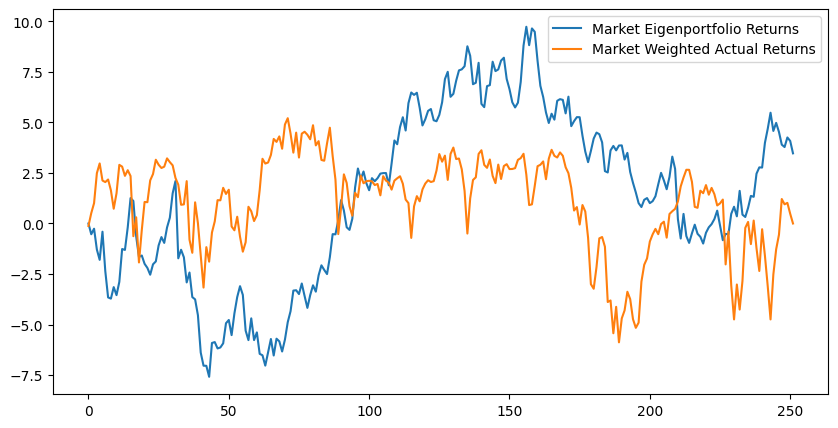

In [416]:
print(max(np.abs(F[0].min()), np.abs(F[0].max())))
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(F[0].cumsum(),  label="Market Eigenportfolio Returns")
ax.plot(R_market.cumsum(), label = "Market Weighted Actual Returns")
plt.legend()

Plot The First Eigenvector

Top 10 Stocks
    Symbol                  Security             GICS Sector
12    AKAM                    Akamai  Information Technology
30     AWK      American Water Works               Utilities
47       T                      AT&T  Communication Services
69      BA                    Boeing             Industrials
137    CMI                   Cummins             Industrials
143   DECK            Deckers Brands  Consumer Discretionary
187   EXPD  Expeditors International             Industrials
199     FE               FirstEnergy               Utilities
249   ILMN                  Illumina             Health Care
502    ZTS                    Zoetis             Health Care

Bottom 10 Stocks
    Symbol            Security             GICS Sector
4      ACN           Accenture  Information Technology
32     AME              Ametek             Industrials
77     BRO       Brown & Brown              Financials
148   FANG  Diamondback Energy                  Energy
154    DPZ            

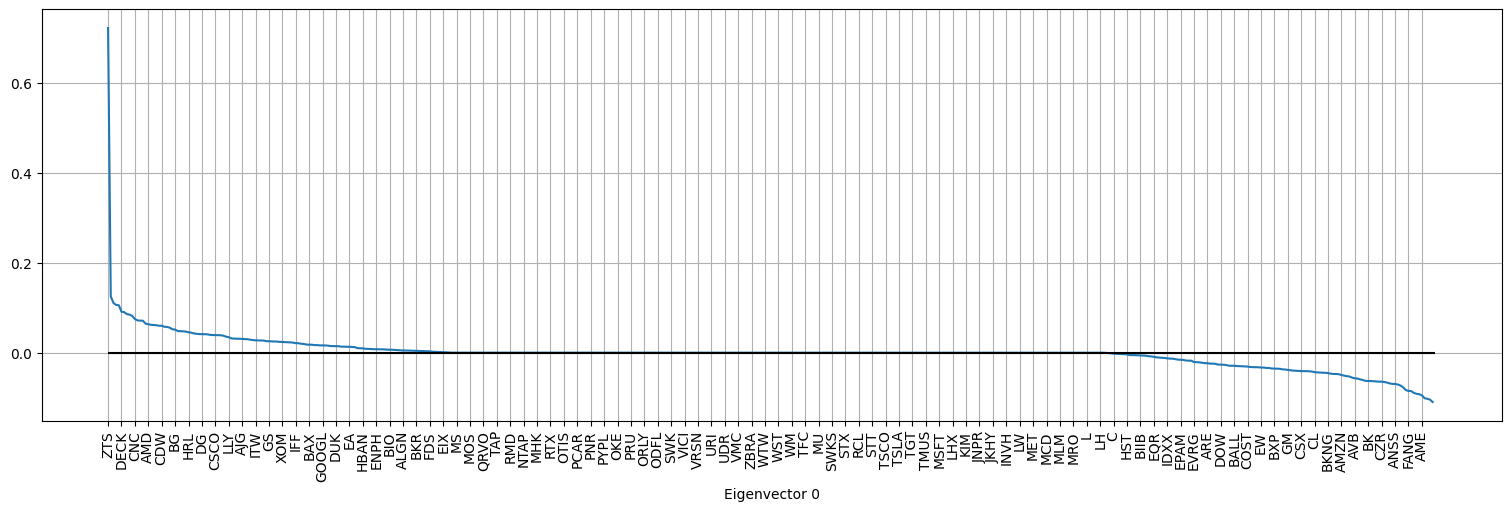

In [417]:
plot_eigenportfolio(0)


Plot the Second Eigenvector

Top 10 Stocks
    Symbol                              Security             GICS Sector
29     AMT                        American Tower             Real Estate
106     CB                         Chubb Limited              Financials
189    XOM                            ExxonMobil                  Energy
241   HUBB                  Hubbell Incorporated             Industrials
252   PODD                               Insulet             Health Care
256     IP                   International Paper               Materials
257    IPG  Interpublic Group of Companies (The)  Communication Services
259   ISRG                    Intuitive Surgical             Health Care
320    MAA     Mid-America Apartment Communities             Real Estate
494    WMB                    Williams Companies                  Energy

Bottom 10 Stocks
    Symbol                      Security             GICS Sector
28     AIG  American International Group              Financials
56    BALL              Ball Corpor

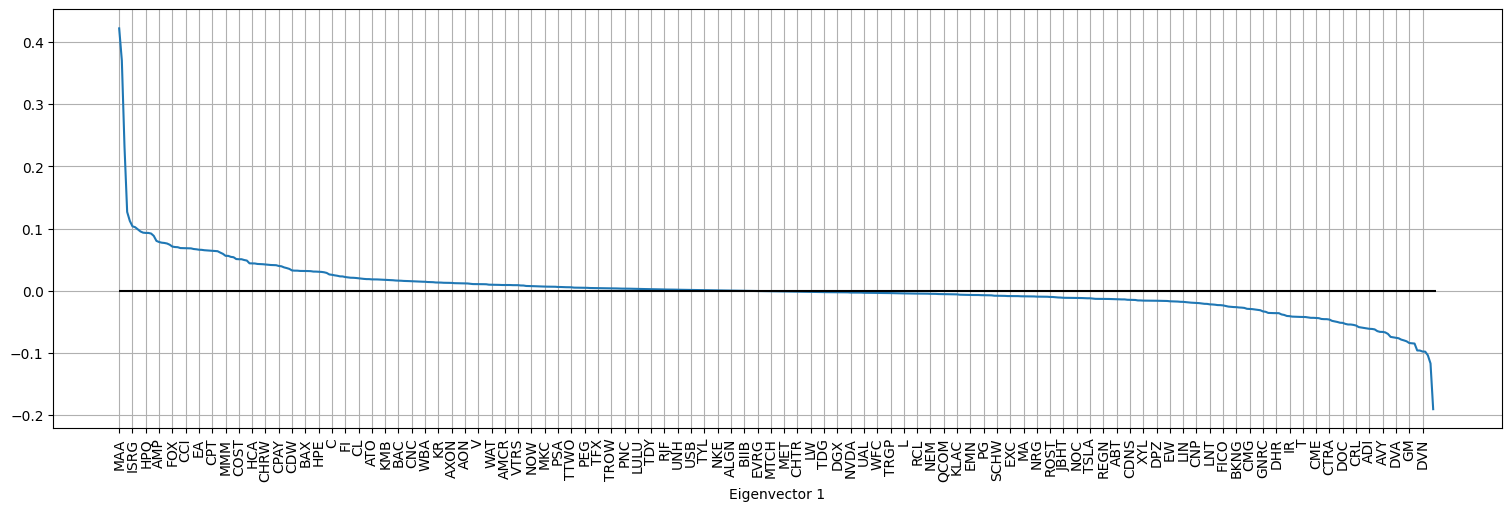

In [418]:
plot_eigenportfolio(1)

Plot the Third Eigenvector

Top 10 Stocks
    Symbol                              Security             GICS Sector
34     APH                              Amphenol  Information Technology
48     ATO                          Atmos Energy               Utilities
95      CE                              Celanese               Materials
180     EL          Estée Lauder Companies (The)        Consumer Staples
209   GRMN                                Garmin  Consumer Discretionary
222     GL                            Globe Life              Financials
257    IPG  Interpublic Group of Companies (The)  Communication Services
494    WMB                    Williams Companies                  Energy
499    YUM                           Yum! Brands  Consumer Discretionary
501    ZBH                         Zimmer Biomet             Health Care

Bottom 10 Stocks
    Symbol                 Security  GICS Sector
25     AAL  American Airlines Group  Industrials
54    AXON          Axon Enterprise  Industrials
104    CVX      Ch

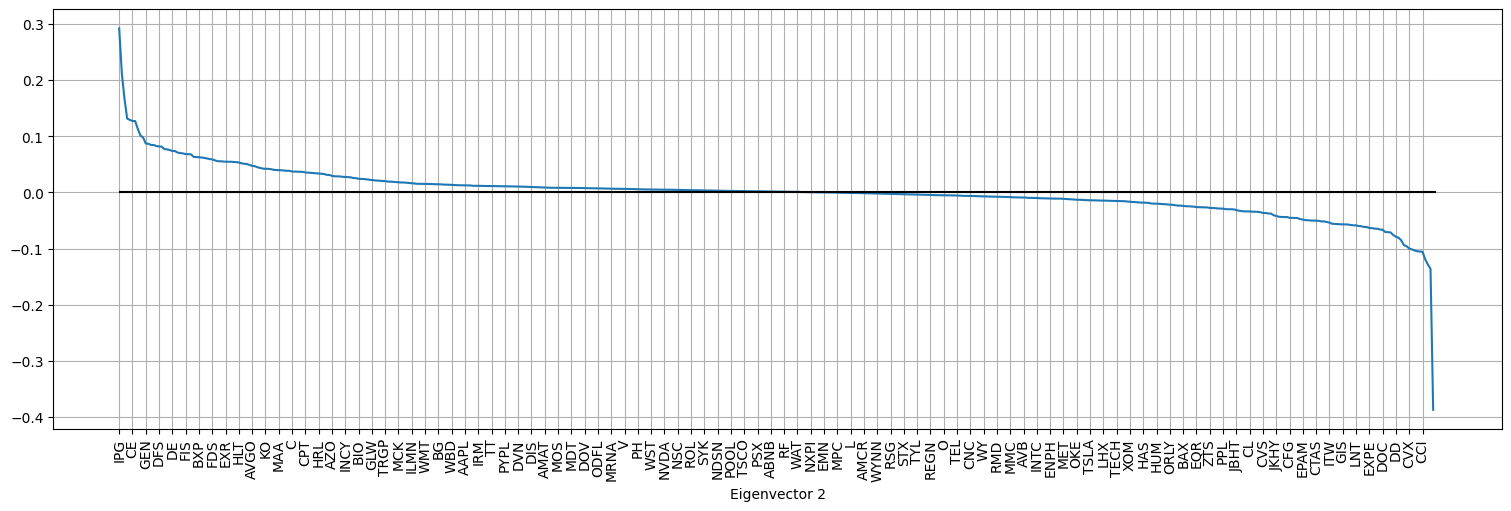

In [419]:
plot_eigenportfolio(2)

Check if the Eigenportfolio returns are uncorrelated

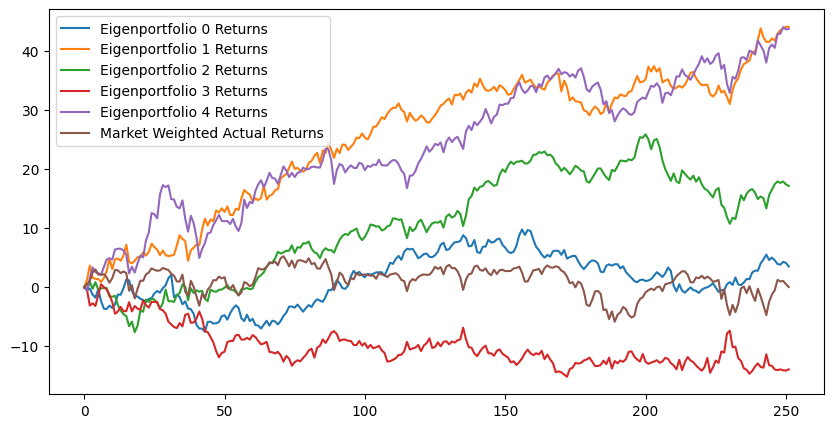

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for i in range(5):
    ax.plot(F[i].cumsum(),  label=f"Eigenportfolio {i} Returns")
ax.plot(R_market.cumsum(), label = "Market Weighted Actual Returns")
plt.legend()

Check if Eigenporfolio return distributions are approximately normal

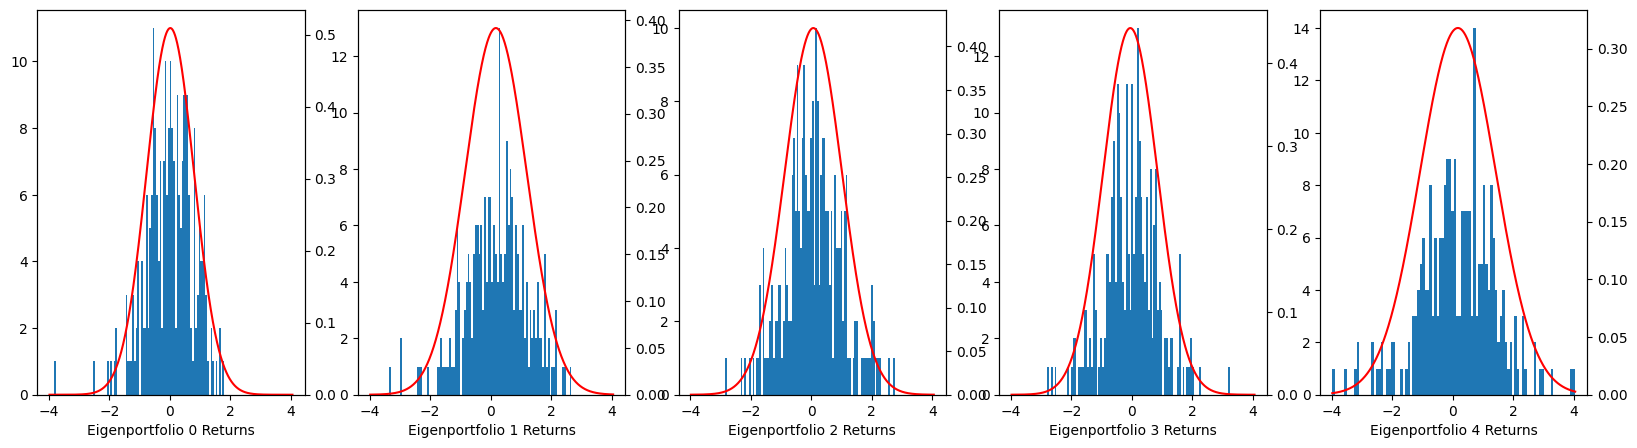

In [421]:
fig, ax = plt.subplots(1, 5, figsize=(20,5))
x =  np.linspace(F[i].min(), F[i].max(), 1000)
   
for i in range(5):
    ax[i].hist(F[i], bins=100)
    params = stats.norm.fit(F[i])
    pdf_fitted = stats.norm.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
    ax[i].set_xlabel(f"Eigenportfolio {i} Returns")
    tx = ax[i].twinx()
    tx.plot(x, pdf_fitted, label='', color = 'r')
    tx.set_ylim(0)


Null Hypothesis (H₀): The datasets are not correlated (correlation coefficient = 0).<br>
Alternative Hypothesis (H₁): The datasets are correlated (correlation coefficient ≠ 0).

In [422]:
from scipy.stats import pearsonr, spearmanr, kendalltau

alpha = 0.05
p_values = {}
for i in range(5):
    for j in range(5):
        if i == j:
            pass
        else:
            # Pearson Correlation
            print(f'\nFor Eigenportfolio {i} and {j}:')
            pearson_corr, pearson_p_value = pearsonr(F[i].to_numpy(), F[j].to_numpy())

            # Interpretation
            if pearson_p_value > alpha:
                print("Pearson correlation: No significant correlation")
            else:
                print("Pearson correlation: Significant correlation")

            p_values[f'{i}-{j}'] = pearson_p_value 



For Eigenportfolio 0 and 1:
Pearson correlation: Significant correlation

For Eigenportfolio 0 and 2:
Pearson correlation: Significant correlation

For Eigenportfolio 0 and 3:
Pearson correlation: Significant correlation

For Eigenportfolio 0 and 4:
Pearson correlation: No significant correlation

For Eigenportfolio 1 and 0:
Pearson correlation: Significant correlation

For Eigenportfolio 1 and 2:
Pearson correlation: Significant correlation

For Eigenportfolio 1 and 3:
Pearson correlation: Significant correlation

For Eigenportfolio 1 and 4:
Pearson correlation: Significant correlation

For Eigenportfolio 2 and 0:
Pearson correlation: Significant correlation

For Eigenportfolio 2 and 1:
Pearson correlation: Significant correlation

For Eigenportfolio 2 and 3:
Pearson correlation: Significant correlation

For Eigenportfolio 2 and 4:
Pearson correlation: Significant correlation

For Eigenportfolio 3 and 0:
Pearson correlation: Significant correlation

For Eigenportfolio 3 and 1:
Pearso

Do Holm's Step-Down Procedure

In [423]:
df_stat=pd.DataFrame()
df_stat['Eigenportfolio pair']=p_values.keys()
df_stat['p_value']=p_values.values()
alpha = 0.05
df_stat.sort_values(by='p_value', inplace=True) # Sort in place!
df_stat['L_thresholds'] = alpha/(df_stat.shape[0] + 1 - (np.arange(df_stat.shape[0]) + 1)) 
# Reject Null Hypothesis = Correlated
df_stat['correlated'] = df_stat['p_value'] < df_stat['L_thresholds']
df_stat.reset_index(drop=True, inplace=True)
print(df_stat)
correlated = max(df_stat.loc[df_stat['correlated'] == True].index +1)
not_correlated = len(df_stat.index) - correlated
print(f'\nNot Correlated: {not_correlated/(correlated+not_correlated) * 100}%')

   Eigenportfolio pair       p_value  L_thresholds  correlated
0                  4-3  1.841794e-15      0.002500        True
1                  3-4  1.841794e-15      0.002632        True
2                  2-4  2.271844e-12      0.002778        True
3                  4-2  2.271844e-12      0.002941        True
4                  3-2  1.868104e-09      0.003125        True
5                  2-3  1.868104e-09      0.003333        True
6                  4-1  1.030437e-08      0.003571        True
7                  1-4  1.030437e-08      0.003846        True
8                  2-1  4.026360e-07      0.004167        True
9                  1-2  4.026360e-07      0.004545        True
10                 1-3  1.706296e-05      0.005000        True
11                 3-1  1.706296e-05      0.005556        True
12                 0-2  5.845896e-04      0.006250        True
13                 2-0  5.845896e-04      0.007143        True
14                 3-0  2.611934e-02      0.008333     

For the 1st 5 Eigenportfolios, 70% show no statistically significant correlation on returns.